In [107]:
%matplotlib inline
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import math
from scipy.stats import skew
from scipy.stats import kurtosis
import matplotlib.colors as mcolors
import scipy.fftpack as fftpack
from scipy import interpolate
import pkg_resources
import types

# ERIC WILL EVENTUALLY MOVE ALL DEFS TO A .PY FILE TO IMPORT HERE
#import tutorialfunctions.py (will contain definitions below)

In [108]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xarray==0.16.2
scipy==1.5.4
pandas==1.1.5
numpy==1.18.5
netCDF4==1.5.5
matplotlib==3.3.3


In [109]:
def test_function(FE_xr):
    
    ust = np.squeeze(FE_xr.fricVel.isel(time=0).values)
    ust_mean = np.mean(np.mean(ust,1),0)
    
    print('Executing test_function: ust_mean =',ust_mean)
    
    return ust_mean

In [110]:
def mean_profiles(FE_xr):
    
    u_3d = np.squeeze(FE_xr.u.isel(time=0).values)
    v_3d = np.squeeze(FE_xr.v.isel(time=0).values)
    th_3d = np.squeeze(FE_xr.theta.isel(time=0).values)
    z_3d = np.squeeze(FE_xr.zPos.isel(time=0).values)

    Nz = u_3d.shape[0]
    wd_1d = np.zeros([Nz])

    u_1d = np.mean(np.mean(u_3d,axis=2),axis=1)
    v_1d = np.mean(np.mean(v_3d,axis=2),axis=1)
    th_1d = np.mean(np.mean(th_3d,axis=2),axis=1)
    z_1d = np.mean(np.mean(z_3d,axis=2),axis=1)

    #ws_1d = np.sqrt(np.power(u_1d,2.0)+np.power(v_1d,2.0))
    for kk in range(0,Nz):
        wd_tmp = math.atan2(-u_1d[kk],-v_1d[kk]) * 180.0 / np.pi
        if (wd_tmp<0.0):
            wd_tmp = 180.0 + (180.0 + wd_tmp)
        wd_1d[kk] = wd_tmp

    array_out = np.zeros([Nz,5])
    array_out[:,0] = z_1d
    array_out[:,1] = u_1d
    array_out[:,2] = v_1d
    array_out[:,3] = wd_1d
    array_out[:,4] = th_1d
    
    return array_out

In [111]:
def turb_profiles(FE_xr):
    
    u_3d = np.squeeze(FE_xr.u.isel(time=0).values)
    v_3d = np.squeeze(FE_xr.v.isel(time=0).values)
    w_3d = np.squeeze(FE_xr.w.isel(time=0).values)
    th_3d = np.squeeze(FE_xr.theta.isel(time=0).values)
    z_3d = np.squeeze(FE_xr.zPos.isel(time=0).values)
    tau13_3d = np.squeeze(FE_xr.Tau31.isel(time=0).values)
    tau23_3d = np.squeeze(FE_xr.Tau32.isel(time=0).values)

    Nz = u_3d.shape[0]
    Ny = u_3d.shape[1]
    Nx = u_3d.shape[2]

    u_1d = np.mean(np.mean(u_3d,axis=2),axis=1)
    v_1d = np.mean(np.mean(v_3d,axis=2),axis=1)
    w_1d = np.mean(np.mean(w_3d,axis=2),axis=1)
    th_1d = np.mean(np.mean(th_3d,axis=2),axis=1)
    z_1d = np.mean(np.mean(z_3d,axis=2),axis=1)
    
    u_2d_mean = np.tile(u_1d,[Nx,1])
    u_3d_mean = np.tile(u_2d_mean,[Ny,1,1])
    u_3d_mean = np.swapaxes(u_3d_mean,0,2)
    u_3d_mean = np.swapaxes(u_3d_mean,1,2)
    
    v_2d_mean = np.tile(v_1d,[Nx,1])
    v_3d_mean = np.tile(v_2d_mean,[Ny,1,1])
    v_3d_mean = np.swapaxes(v_3d_mean,0,2)
    v_3d_mean = np.swapaxes(v_3d_mean,1,2)
    
    w_2d_mean = np.tile(w_1d,[Nx,1])
    w_3d_mean = np.tile(w_2d_mean,[Ny,1,1])
    w_3d_mean = np.swapaxes(w_3d_mean,0,2)
    w_3d_mean = np.swapaxes(w_3d_mean,1,2)
    
    th_2d_mean = np.tile(th_1d,[Nx,1])
    th_3d_mean = np.tile(th_2d_mean,[Ny,1,1])
    th_3d_mean = np.swapaxes(th_3d_mean,0,2)
    th_3d_mean = np.swapaxes(th_3d_mean,1,2)
    
    up = u_3d - u_3d_mean
    vp = v_3d - v_3d_mean
    wp = w_3d - w_3d_mean
    thp = th_3d - th_3d_mean
    
    upup = up*up
    upwp = up*wp
    vpvp = vp*vp
    vpwp = vp*wp
    wpwp = wp*wp
    thpwp = thp*wp
    tke = 0.5*(upup+vpvp+wpwp)
    
    upup_1d = np.mean(np.mean(upup,axis=2),axis=1)
    upwp_1d = np.mean(np.mean(upwp,axis=2),axis=1)
    vpvp_1d = np.mean(np.mean(vpvp,axis=2),axis=1)
    vpwp_1d = np.mean(np.mean(vpwp,axis=2),axis=1)
    tau13_1d = np.mean(np.mean(tau13_3d,axis=2),axis=1)
    tau23_1d = np.mean(np.mean(tau23_3d,axis=2),axis=1)
    
    Upwp_1d = np.sqrt(np.power(upwp_1d,2.0)+np.power(vpwp_1d,2.0))
    #Upwp_1d = np.mean(np.mean(np.sqrt(np.power(upwp,2.0)+np.power(vpwp,2.0)),axis=2),axis=1)
    wpwp_1d = np.mean(np.mean(wpwp,axis=2),axis=1)
    tke_1d = np.mean(np.mean(tke,axis=2),axis=1)
    thpwp_1d = np.mean(np.mean(thpwp,axis=2),axis=1)
    #tau1323_1d = np.mean(np.mean(np.sqrt(np.power(tau13_3d,2.0)+np.power(tau23_3d,2.0)),axis=2),axis=1)
    tau1323_1d = np.sqrt(np.power(tau13_1d,2.0)+np.power(tau23_1d,2.0))
    #tau1323_1d = np.mean(np.mean(tau13_3d,axis=2),axis=1) + np.mean(np.mean(tau23_3d,axis=2),axis=1)
    
    array_out = np.zeros([Nz,10])
    array_out[:,0] = z_1d
    array_out[:,1] = upup_1d
    array_out[:,2] = upwp_1d
    array_out[:,3] = vpvp_1d
    array_out[:,4] = vpwp_1d
    array_out[:,5] = Upwp_1d
    array_out[:,6] = wpwp_1d
    array_out[:,7] = tke_1d
    array_out[:,8] = thpwp_1d
    array_out[0:Nz-1,9] = 0.5*(tau1323_1d[0:Nz-1]+tau1323_1d[1:Nz])
    #array_out[:,9] = tau1323_1d
                               
    return array_out

In [112]:
def plot_XY_UVWTHETA(case,save_plot_opt):

    if case == 'neutral':
        ufield = case_0.u.isel(time=0).values
        vfield = case_0.v.isel(time=0).values
        wfield = case_0.w.isel(time=0).values
        thetafield = case_0.theta.isel(time=0).values
        xPos = case_0.xPos.isel(time=0,zIndex=zChoose).values
        yPos = case_0.yPos.isel(time=0,zIndex=zChoose).values
        zPos = case_0.zPos.isel(time=0,zIndex=zChoose).values
        #xticks_vals=[0,1.0,2.0,3.0,4.0]
        #xticks_ticks=['0','1.0','2.0','3.0','4.0']
        xticks_vals=[0,3.2,6.4,9.6,12.8]
        xticks_ticks=['0','3.2','6.4','9.6','12.8']
        #yticks_vals=[0,1.0,2.0,3.0,4.0]
        #yticks_ticks=['0','1.0','2.0','3.0','4.0']
        yticks_vals=[0,3.170,6.340,9.510,12.68]
        yticks_ticks=['0','3.170','6.340','9.510','12.68']
    elif case == 'convective':
        ufield = case_1.u.isel(time=0).values
        vfield = case_1.v.isel(time=0).values
        wfield = case_1.w.isel(time=0).values
        thetafield = case_1.theta.isel(time=0).values
        xPos = case_1.xPos.isel(time=0,zIndex=zChoose).values
        yPos = case_1.yPos.isel(time=0,zIndex=zChoose).values
        zPos = case_1.zPos.isel(time=0,zIndex=zChoose).values
        xticks_vals=[0,1.5,3.0,4.5,6.0]
        xticks_ticks=['0','1.5','3.0','4.5','6.0']
        yticks_vals=[0,1.5,3.0,4.5,6.0]
        yticks_ticks=['0','1.5','3.0','4.5','6.0']
    elif case == 'stable':
        ufield = case_2.u.isel(time=0).values
        vfield = case_2.v.isel(time=0).values
        wfield = case_2.w.isel(time=0).values
        thetafield = case_2.theta.isel(time=0).values
        xPos = case_2.xPos.isel(time=0,zIndex=zChoose).values
        yPos = case_2.yPos.isel(time=0,zIndex=zChoose).values
        zPos = case_2.zPos.isel(time=0,zIndex=zChoose).values
        xticks_vals=[0,0.10,0.20,0.3,0.4]
        xticks_ticks=['0','0.1','0.2','0.3','0.4']
        yticks_vals=[0,0.10,0.20,0.3,0.4]
        yticks_ticks=['0','0.1','0.2','0.3','0.4']
    else:
        print("ERROR: INVALID CASE SELECTED")
        
    u_min = np.amin(np.amin(ufield))
    u_max = np.amax(np.amax(ufield))
    v_min = np.amin(np.amin(vfield))
    v_max = np.amax(np.amax(vfield))
    w_min = np.amin(np.amin(wfield))
    w_max = np.amax(np.amax(wfield))
    t_min = np.amin(np.amin(thetafield[zChoose,:,:]))
    t_max = np.amax(np.amax(thetafield[zChoose,:,:]))
    
    fig_name = "UVWTHETA-XY-"+case+".png"
    colormap1 = 'viridis'
    colormap2 = 'seismic'
    colormap3 = 'YlOrRd'
    FE_legend = [r'u [m/s] at z='+str(np.amax(zPos))+' m',r'v [m/s] at z='+str(np.amax(zPos))+' m',r'w [m/s] at z='+str(np.amax(zPos))+' m', \
                 '\u03B8 [K] at z='+str(np.amax(zPos))+' m']
    
    fntSize=20
    fntSize_title=22
    plt.rcParams['xtick.labelsize']=fntSize
    plt.rcParams['ytick.labelsize']=fntSize
    plt.rcParams['axes.linewidth']=2.0
    plt.rcParams['pcolor.shading']='auto'

    numPlotsX=2
    numPlotsY=2
    fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(26,20))

    ###############
    ### U plot ###
    ###############
    ax=axs[0][0]
    im = ax.pcolormesh(xPos/1e3,yPos/1e3,ufield[zChoose,:,:],cmap=colormap1,linewidth=0,rasterized=True,vmin=u_min,vmax=u_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
    ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_0 = FE_legend[0]
    ax.set_title(title_fig_0,fontsize=fntSize)

    ###############
    ### V plot ###
    ###############
    ax=axs[1][0]
    im = ax.pcolormesh(xPos/1e3,yPos/1e3,vfield[zChoose,:,:],cmap=colormap1,linewidth=0,rasterized=True,vmin=v_min,vmax=v_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
    ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_1 = FE_legend[1]
    ax.set_title(title_fig_1,fontsize=fntSize)

    ###############
    ### W plot ###
    ###############
    ax=axs[0][1]
    im = ax.pcolormesh(xPos/1e3,yPos/1e3,wfield[zChoose,:,:],cmap=colormap2,linewidth=0,rasterized=True,vmin=w_min,vmax=w_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
    ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_2 = FE_legend[2]
    ax.set_title(title_fig_2,fontsize=fntSize)
    
    ###############
    ### THETA plot ###
    ###############
    ax=axs[1][1]
    im = ax.pcolormesh(xPos/1e3,yPos/1e3,thetafield[zChoose,:,:],cmap=colormap3,linewidth=0,rasterized=True,vmin=t_min,vmax=t_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$y$ $[\mathrm{km}]$',fontsize=fntSize)
    ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_3 = FE_legend[3]
    ax.set_title(title_fig_3,fontsize=fntSize)

    if (save_plot_opt==1):
        print(path_figure + fig_name)
        plt.savefig(path_figure + fig_name,dpi=300,bbox_inches = "tight")

In [125]:
def plot_XZ_UVWTHETA(case,save_plot_opt):
    
    numPlotsX=4
    numPlotsY=1
    
    if case == 'neutral':
        ufield = case_0.u.isel(time=0).values
        vfield = case_0.v.isel(time=0).values
        wfield = case_0.w.isel(time=0).values
        thetafield = case_0.theta.isel(time=0).values
        xPos = case_0.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_0.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_0.zPos.isel(time=0,yIndex=yChoose).values
        #xticks_vals=[0,1.0,2.0,3.0,4.0]
        #xticks_ticks=['0','1.0','2.0','3.0','4.0']
        xticks_vals=[0,3.2,6.4,9.6,12.8]
        xticks_ticks=['0','3.2','6.4','9.6','12.8']
        #yticks_vals=[0,0.729,1.458,2.187,2.916]
        #yticks_ticks=['0','0.729','1.458','2.187','2.916']
        yticks_vals=[0,0.287,0.574,0.861,1.148]
        yticks_ticks=['0','0.287','0.574','0.861','1.148']
    elif case == 'convective':
        ufield = case_1.u.isel(time=0).values
        vfield = case_1.v.isel(time=0).values
        wfield = case_1.w.isel(time=0).values
        thetafield = case_1.theta.isel(time=0).values
        xPos = case_1.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_1.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_1.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,1.5,3.0,4.5,6.0]
        xticks_ticks=['0','1.5','3.0','4.5','6.0']
        yticks_vals=[0,0.729,1.458,2.187,2.916]
        yticks_ticks=['0','0.729','1.458','2.187','2.916']
    elif case == 'stable':
        ufield = case_2.u.isel(time=0).values
        vfield = case_2.v.isel(time=0).values
        wfield = case_2.w.isel(time=0).values
        thetafield = case_2.theta.isel(time=0).values
        xPos = case_2.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_2.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_2.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,0.10,0.20,0.3,0.4]
        xticks_ticks=['0','0.1','0.2','0.3','0.4']
        yticks_vals=[0,0.243,0.486,0.729,0.972]
        yticks_ticks=['0','0.243','0.486','0.729','0.972']
    else:
         print("ERROR: INVALID CASE SELECTED")
            
    u_min = np.amin(np.amin(ufield))
    u_max = np.amax(np.amax(ufield))
    v_min = np.amin(np.amin(vfield))
    v_max = np.amax(np.amax(vfield))
    w_min = np.amin(np.amin(wfield))
    w_max = np.amax(np.amax(wfield))
    t_min = np.amin(np.amin(thetafield))
    t_max = np.amax(np.amax(thetafield))
    
    print(np.amax(zPos))

    fig_name = "UVWTHETA-XZ-"+case+".png"
    colormap1 = 'viridis'
    colormap2 = 'seismic'
    colormap3 = 'YlOrRd'
    FE_legend = [r'u [m/s] at y='+str(yPos[0,yChoose]/1e3)+' km',r'v [m/s] at y='+str(yPos[0,yChoose]/1e3)+' km',r'w [m/s] at y='+str(yPos[0,yChoose]/1e3)+' km', \
                 '\u03B8 [K] at y='+str(yPos[0,yChoose]/1e3)+' km']
    
    fntSize=20
    fntSize_title=22
    plt.rcParams['xtick.labelsize']=fntSize
    plt.rcParams['ytick.labelsize']=fntSize
    plt.rcParams['axes.linewidth']=2.0
    plt.rcParams['pcolor.shading']='auto'
    
    fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(26,20))

    ###############
    ### U plot ###
    ###############
    ax=axs[0]
    im = ax.pcolormesh(xPos/1e3,zPos/1e3,ufield[:,yChoose,:],cmap=colormap1,linewidth=0,rasterized=True,vmin=u_min,vmax=u_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$z$ $[\mathrm{km}]$',fontsize=fntSize)
    #ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_0 = FE_legend[0]
    ax.set_title(title_fig_0,fontsize=fntSize)

    ###############
    ### V plot ###
    ###############
    ax=axs[1]
    im = ax.pcolormesh(xPos/1e3,zPos/1e3,vfield[:,yChoose,:],cmap=colormap1,linewidth=0,rasterized=True,vmin=v_min,vmax=v_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$z$ $[\mathrm{km}]$',fontsize=fntSize)
    #ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_1 = FE_legend[1]
    ax.set_title(title_fig_1,fontsize=fntSize)

    ###############
    ### W plot ###
    ###############
    ax=axs[2]
    im = ax.pcolormesh(xPos/1e3,zPos/1e3,wfield[:,yChoose,:],cmap=colormap2,linewidth=0,rasterized=True,vmin=w_min,vmax=w_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$z$ $[\mathrm{km}]$',fontsize=fntSize)
    #ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')
    
    title_fig_2 = FE_legend[2]
    ax.set_title(title_fig_2,fontsize=fntSize)
    
    ###############
    ### THETA plot ###
    ###############
    ax=axs[3]
    im = ax.pcolormesh(xPos/1e3,zPos/1e3,thetafield[:,yChoose,:],cmap=colormap3,linewidth=0,rasterized=True,vmin=t_min,vmax=t_max)
    ax.set_xticks(xticks_vals)
    ax.set_xticklabels(xticks_ticks)
    ax.set_yticks(yticks_vals)
    ax.set_yticklabels(yticks_ticks)
    ax.set_ylabel(r'$z$ $[\mathrm{km}]$',fontsize=fntSize)
    ax.set_xlabel(r'$x$ $[\mathrm{km}]$',fontsize=fntSize)
    cbar=fig.colorbar(im, ax=ax) #, orientation='horizontal')

    title_fig_3 = FE_legend[3]
    ax.set_title(title_fig_3,fontsize=fntSize)

    # save figure
    if (save_plot_opt==1):
        print(path_figure + fig_name)
        plt.savefig(path_figure + fig_name,dpi=300,bbox_inches = "tight")

In [126]:
def plot_mean_profiles(case, save_plot_option):

    colores_v = []
    colores_v.append('darkblue')
    colores_v.append('darkred')
    colores_v.append('dodgerblue')
    colores_v.append('orangered')

    lineas_v = []
    lineas_v.append('-')
    lineas_v.append('--')
    lineas_v.append('-.')
    lineas_v.append('.')
  
    y_min = 0.0
    y_max = 700.0 # FE_mean_MO[FE_mean_MO.shape[0]-1,0]

    if case == 'neutral':
        ufield = case_0.u.isel(time=0).values
        vfield = case_0.v.isel(time=0).values
        wfield = case_0.w.isel(time=0).values
        thetafield = case_0.theta.isel(time=0).values
        fricVelfield = case_0.fricVel.isel(time=0).values
        #tkefield = case_0.TKE_0.isel(time=0).values
        xPos = case_0.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_0.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_0.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,1.0,2.0,3.0,4.0]
        xticks_ticks=['0','1.0','2.0','3.0','4.0']
        #yticks_vals=[0,0.3645,0.729,1.0935,1.458]
        #yticks_ticks=['0','0.3645','0.729','1.0935','1.458']
        yticks_vals=[0,0.287,0.574,0.861,1.148]
        yticks_ticks=['0','0.287','0.574','0.861','1.148']
    elif case == 'convective':
        ufield = case_1.u.isel(time=0).values
        vfield = case_1.v.isel(time=0).values
        wfield = case_1.w.isel(time=0).values
        thetafield = case_1.theta.isel(time=0).values
        #tkefield = case_1.TKE_0.isel(time=0).values
        xPos = case_1.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_1.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_1.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,1.5,3.0,4.5,6.0]
        xticks_ticks=['0','1.5','3.0','4.5','6.0']
        yticks_vals=[0,0.729,1.458,2.187,2.916]
        yticks_ticks=['0','0.729','1.458','2.187','2.916']
    elif case == 'stable':
        numPlotsX=1
        numPlotsY=3
        ufield = case_2.u.isel(time=0).values
        vfield = case_2.v.isel(time=0).values
        wfield = case_2.w.isel(time=0).values
        thetafield = case_2.theta.isel(time=0).values
        #tkefield = case_2.TKE_0.isel(time=0).values
        xPos = case_2.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_2.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_2.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,0.10,0.20,0.3,0.4]
        xticks_ticks=['0','0.1','0.2','0.3','0.4']
        yticks_vals=[0,0.243,0.486,0.729,0.972]
        yticks_ticks=['0','0.243','0.486','0.729','0.972']
    else:
         print("ERROR: INVALID CASE SELECTED")
            
    yaxis_ticks = yticks_vals
    yaxis_vals = yticks_ticks
    yaxis_vals_empty = ['','','','','']
    
    print(zPos.shape)
    print(np.amax(zPos/1000.0))
    
    spdtemp = ufield * ufield + vfield * vfield + wfield * wfield
    spdfield = np.power(spdtemp,0.5)
    mean_U = np.mean(ufield,axis=(1,2))
    mean_V = np.mean(vfield,axis=(1,2))
    mean_THETA = np.mean(thetafield,axis=(1,2))
    mean_SPD = np.mean(spdfield,axis=(1,2))
    #mean_TKE = np.mean(tkefield,axis=(1,2))
    if case == 'neutral':
        mean_FRICVEL=np.mean(fricVelfield,axis=(0,1))
        print(fricVelfield.shape)
        print(mean_FRICVEL.shape)
    
    fntSize=20
    fntSize_title=22
    fntSize_legend=16
    plt.rcParams['xtick.labelsize']=fntSize
    plt.rcParams['ytick.labelsize']=fntSize
    plt.rcParams['axes.linewidth']=2.0
    numPlotsX=1
    numPlotsY=4
    fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(28,12))
    
    fig_name = "MEAN-PROF-"+case+".png"
    
    ###############
    ### panel 0 ###
    ###############
    ax = axs[0]
    im = ax.plot(mean_SPD,zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    if case == 'neutral':
        im2 = ax.plot((mean_FRICVEL/0.4)*np.log(zPos[:,0]/np.amax(case_0.z0m.isel(time=0).values)),zPos[:,0]/1000.0,lineas_v[1],color=colores_v[1],linewidth=2.5,markersize=8,label='log law')
    #ax.set_ylim([y_min,y_max])
    ax.set_xlabel(r"$WS$ $[$m s$^{-1}]$",fontsize=fntSize)
    ax.set_ylabel(r"$z$ $[$km$]$",fontsize=fntSize)
    ax.grid(True)
    ax.legend(loc=2,prop={'size': fntSize},edgecolor='white')
    ax.set_yticks(yaxis_ticks)
    ax.set_yticklabels(yaxis_vals,fontsize=fntSize)
    
    ###############
    ### panel 1 ###
    ###############
    ax = axs[1]
    im = ax.plot(mean_U,zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    #ax.set_ylim([y_min,y_max])
    ax.set_xlabel(r"$U$ $[$m s$^{-1}]$",fontsize=fntSize)
    #ax.set_ylabel(r"$z$ $[$km$]$",fontsize=fntSize)
    ax.grid(True)
    #ax.legend(loc=2,prop={'size': fntSize_legend},edgecolor='white')
    ax.set_yticks(yaxis_ticks)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    
    ###############
    ### panel 2 ###
    ###############
    ax = axs[2]
    im = ax.plot(mean_V,zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    #ax.set_ylim([y_min,y_max])
    ax.set_xlabel(r"$V$ $[$m s$^{-1}]$",fontsize=fntSize)
    #ax.set_ylabel(r"$z$ $[$m$]$",fontsize=fntSize)
    ax.grid(True)
    #ax.legend(loc=2,prop={'size': fntSize_legend},edgecolor='white')
    ax.set_yticks(yaxis_ticks)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    
    ###############
    ### panel 3 ###
    ###############
    ax = axs[3]
    im = ax.plot(mean_THETA,zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    #ax.set_ylim([y_min,y_max])
    ax.set_xlabel("\u03B8 [K]",fontsize=fntSize)
    #ax.set_ylabel(r"$z$ $[$km$]$",fontsize=fntSize)
    ax.grid(True)
    #ax.legend(loc=2,prop={'size': fntSize_legend},edgecolor='white')
    ax.set_yticks(yaxis_ticks)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    
    if (save_plot_opt==1):
        print(path_figure + fig_name)
        plt.savefig(path_figure + fig_name,dpi=300,bbox_inches = "tight")

In [127]:
def compute_turb_profiles(FE_xr, array_out):
    
    u_3d = np.squeeze(FE_xr.u.isel(time=0).values)
    v_3d = np.squeeze(FE_xr.v.isel(time=0).values)
    w_3d = np.squeeze(FE_xr.w.isel(time=0).values)
    th_3d = np.squeeze(FE_xr.theta.isel(time=0).values)
    z_3d = np.squeeze(FE_xr.zPos.isel(time=0).values)
    tau13_3d = np.squeeze(FE_xr.Tau31.isel(time=0).values)
    tau23_3d = np.squeeze(FE_xr.Tau32.isel(time=0).values)

    Nz = u_3d.shape[0]
    Ny = u_3d.shape[1]
    Nx = u_3d.shape[2]

    u_1d = np.mean(np.mean(u_3d,axis=2),axis=1)
    v_1d = np.mean(np.mean(v_3d,axis=2),axis=1)
    w_1d = np.mean(np.mean(w_3d,axis=2),axis=1)
    th_1d = np.mean(np.mean(th_3d,axis=2),axis=1)
    z_1d = np.mean(np.mean(z_3d,axis=2),axis=1)
    
    u_2d_mean = np.tile(u_1d,[Nx,1])
    u_3d_mean = np.tile(u_2d_mean,[Ny,1,1])
    u_3d_mean = np.swapaxes(u_3d_mean,0,2)
    u_3d_mean = np.swapaxes(u_3d_mean,1,2)
    
    v_2d_mean = np.tile(v_1d,[Nx,1])
    v_3d_mean = np.tile(v_2d_mean,[Ny,1,1])
    v_3d_mean = np.swapaxes(v_3d_mean,0,2)
    v_3d_mean = np.swapaxes(v_3d_mean,1,2)
    
    w_2d_mean = np.tile(w_1d,[Nx,1])
    w_3d_mean = np.tile(w_2d_mean,[Ny,1,1])
    w_3d_mean = np.swapaxes(w_3d_mean,0,2)
    w_3d_mean = np.swapaxes(w_3d_mean,1,2)
    
    th_2d_mean = np.tile(th_1d,[Nx,1])
    th_3d_mean = np.tile(th_2d_mean,[Ny,1,1])
    th_3d_mean = np.swapaxes(th_3d_mean,0,2)
    th_3d_mean = np.swapaxes(th_3d_mean,1,2)
    
    up = u_3d - u_3d_mean
    vp = v_3d - v_3d_mean
    wp = w_3d - w_3d_mean
    thp = th_3d - th_3d_mean
    
    upup = up*up
    upwp = up*wp
    vpvp = vp*vp
    vpwp = vp*wp
    wpwp = wp*wp
    thpwp = thp*wp
    tke = 0.5*(upup+vpvp+wpwp)
    
    upup_1d = np.mean(np.mean(upup,axis=2),axis=1)
    upwp_1d = np.mean(np.mean(upwp,axis=2),axis=1)
    vpvp_1d = np.mean(np.mean(vpvp,axis=2),axis=1)
    vpwp_1d = np.mean(np.mean(vpwp,axis=2),axis=1)
    tau13_1d = np.mean(np.mean(tau13_3d,axis=2),axis=1)
    tau23_1d = np.mean(np.mean(tau23_3d,axis=2),axis=1)
    
    Upwp_1d = np.sqrt(np.power(upwp_1d,2.0)+np.power(vpwp_1d,2.0))
    #Upwp_1d = np.mean(np.mean(np.sqrt(np.power(upwp,2.0)+np.power(vpwp,2.0)),axis=2),axis=1)
    wpwp_1d = np.mean(np.mean(wpwp,axis=2),axis=1)
    tke_1d = np.mean(np.mean(tke,axis=2),axis=1)
    thpwp_1d = np.mean(np.mean(thpwp,axis=2),axis=1)
    #tau1323_1d = np.mean(np.mean(np.sqrt(np.power(tau13_3d,2.0)+np.power(tau23_3d,2.0)),axis=2),axis=1)
    tau1323_1d = np.sqrt(np.power(tau13_1d,2.0)+np.power(tau23_1d,2.0))
    #tau1323_1d = np.mean(np.mean(tau13_3d,axis=2),axis=1) + np.mean(np.mean(tau23_3d,axis=2),axis=1)
    
    array_out = np.zeros([Nz,15])
    array_out[:,0] = z_1d
    array_out[:,1] = upup_1d
    array_out[:,2] = upwp_1d
    array_out[:,3] = vpvp_1d
    array_out[:,4] = vpwp_1d
    array_out[:,5] = Upwp_1d
    array_out[:,6] = wpwp_1d
    array_out[:,7] = tke_1d
    array_out[:,8] = thpwp_1d
    array_out[0:Nz-1,9] = 0.5*(tau1323_1d[0:Nz-1]+tau1323_1d[1:Nz])
    array_out[:,10] = 0.5*(upup_1d*upup_1d+vpwp_1d*vpwp_1d+wpwp_1d*wpwp_1d)
    #array_out[:,9] = tau1323_1d
                               
    return array_out

In [128]:
def plot_turb_profiles(case, FE_turb_tmp, save_plot_option):

    colores_v = []
    colores_v.append('darkblue')
    colores_v.append('darkred')
    colores_v.append('dodgerblue')
    colores_v.append('orangered')

    lineas_v = []
    lineas_v.append('-')
    lineas_v.append('--')
    lineas_v.append('-.')
    lineas_v.append('.')
  
    y_min = 0.0
    y_max = 700.0 # FE_mean_MO[FE_mean_MO.shape[0]-1,0]

    #yaxis_ticks = [0,100,200,300,400,500,600,700]
   # yaxis_vals = ['0','100','200','300','400','500','600','700']
    #yaxis_vals_empty = ['','','','','','','','']

    print(case)
    if case == 'neutral':
        ufield = case_0.u.isel(time=0).values
        vfield = case_0.v.isel(time=0).values
        wfield = case_0.w.isel(time=0).values
        thetafield = case_0.theta.isel(time=0).values
        #tkefield = case_0.TKE_0.isel(time=0).values
        xPos = case_0.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_0.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_0.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,1.0,2.0,3.0,4.0]
        xticks_ticks=['0','1.0','2.0','3.0','4.0']
        #yticks_vals=[0,0.3645,0.729,1.0935,1.458]
        #yticks_ticks=['0','0.3645','0.729','1.0935','1.458']
        yticks_vals=[0,0.287,0.574,0.861,1.148]
        yticks_ticks=['0','0.287','0.574','0.861','1.148']
    elif case == 'convective':
        ufield = case_1.u.isel(time=0).values
        vfield = case_1.v.isel(time=0).values
        wfield = case_1.w.isel(time=0).values
        thetafield = case_1.theta.isel(time=0).values
        #tkefield = case_1.TKE_0.isel(time=0).values
        xPos = case_1.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_1.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_1.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,1.5,3.0,4.5,6.0]
        xticks_ticks=['0','1.5','3.0','4.5','6.0']
        yticks_vals=[0,0.729,1.458,2.187,2.916]
        yticks_ticks=['0','0.729','1.458','2.187','2.916']
    elif case == 'stable':
        numPlotsX=1
        numPlotsY=3
        ufield = case_2.u.isel(time=0).values
        vfield = case_2.v.isel(time=0).values
        wfield = case_2.w.isel(time=0).values
        thetafield = case_2.theta.isel(time=0).values
        #tkefield = case_2.TKE_0.isel(time=0).values
        xPos = case_2.xPos.isel(time=0,yIndex=yChoose).values
        yPos = case_2.yPos.isel(time=0,yIndex=yChoose).values
        zPos = case_2.zPos.isel(time=0,yIndex=yChoose).values
        xticks_vals=[0,0.10,0.20,0.3,0.4]
        xticks_ticks=['0','0.1','0.2','0.3','0.4']
        yticks_vals=[0,0.243,0.486,0.729,0.972]
        yticks_ticks=['0','0.243','0.486','0.729','0.972']
    else:
         print("ERROR: INVALID CASE SELECTED")
            
    yaxis_ticks = yticks_vals
    yaxis_vals = yticks_ticks
    yaxis_vals_empty = ['','','','','']


    fntSize=20
    fntSize_title=22
    fntSize_legend=16
    plt.rcParams['xtick.labelsize']=fntSize
    plt.rcParams['ytick.labelsize']=fntSize
    plt.rcParams['axes.linewidth']=2.0

    numPlotsX=1
    numPlotsY=4
    fig,axs = plt.subplots(numPlotsX,numPlotsY,sharey=False,sharex=False,figsize=(28,12))

    ###############
    ### panel 0 ###
    ###############
    ax = axs[0]
    im2 = ax.plot(FE_turb_tmp[:,10]+FE_turb_tmp[:,7],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case+': total')
    im2 = ax.plot(FE_turb_tmp[:,10],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[1],linewidth=2.5,markersize=8,label=case+': res.')
    im2 = ax.plot(FE_turb_tmp[:,7],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[2],linewidth=2.5,markersize=8,label=case+': SGS')
    ax.set_xlabel(r"TKE $[$m$^2$ s$^{-2}]$",fontsize=fntSize)
    ax.set_ylabel(r"$z$ $[$km$]$",fontsize=fntSize)
    ax.legend(loc=1,prop={'size': fntSize_legend},edgecolor='white')
    ax.set_yticks(yaxis_ticks)
    ax.grid(True)
    ax.set_yticklabels(yaxis_vals,fontsize=fntSize)
    
    ###############
    ### panel 1 ###
    ###############
    ax = axs[1]
    im2 = ax.plot(FE_turb_tmp[:,6],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    ax.set_xlabel(r"$\sigma_w^2$ $[$m$^2$ s$^{-2}]$",fontsize=fntSize)
    ax.set_yticks(yaxis_ticks)
    ax.grid(True)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    
    ###############
    ### panel 2 ###
    ###############
    ax = axs[2]
    im2 = ax.plot(FE_turb_tmp[:,8],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case)
    ax.set_yticks(yaxis_ticks)
    ax.grid(True)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    ax.set_xlabel(r"$\langle W' TH' \rangle$ $[$m K s$^{-1}]$",fontsize=fntSize)
    
    ###############
    ### panel 3 ###
    ###############
    ax = axs[3]
    im2 = ax.plot(FE_turb_tmp[:,5]+FE_turb_tmp[:,9],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[0],linewidth=2.5,markersize=8,label=case+': total')
    im2 = ax.plot(FE_turb_tmp[:,5],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[1],linewidth=2.5,markersize=8,label=case+': res.')
    im2 = ax.plot(FE_turb_tmp[:,9],zPos[:,0]/1000.0,lineas_v[0],color=colores_v[2],linewidth=2.5,markersize=8,label=case+': SGS')
    ax.set_xlabel(r"$\sigma_w^2$ $[$m$^2$ s$^{-2}]$",fontsize=fntSize)
    ax.set_yticks(yaxis_ticks)
    ax.grid(True)
    ax.set_yticklabels(yaxis_vals_empty,fontsize=fntSize)
    ax.set_xlabel(r"$\langle U' w' \rangle$ $[$m$^2$ s$^{-2}]$",fontsize=fntSize)
    
    fig_name = "TURB-PROF-"+case+".png"
    
    if (save_plot_opt==1):
        print(path_figure + fig_name)
        plt.savefig(path_figure + fig_name,dpi=300,bbox_inches = "tight")

# FASTEDDY TUTORIAL VISUALIZATION AND ANALYSIS NOTEBOOK

# 1. Define cases and data locations

In [145]:
##########################
# BEGIN USER EDIT REGION #
##########################
case = 'stable' #'neutral' #'convective' #'stable' #'convective'  # USER SELECTED CASE ('stable', 'convective', or 'neutral')
zChoose = 5 # VERTICAL INDEX TO MAKE XY PLOTS
yChoose = 64 # 317-neutral #300-convective 64-stable
path_base = "/glade/scratch/erichend/FastEddy/tutorial/"
output_base = ["FE_NBL.","FE_TEST.","FE_SBL."] 
path_end = "/output/"
FE_timestep = ['504000','540000','4320000']    # FINAL TIME STEPS OF CASES
cases_FE = ['neutral3','convective3','stable3'] # PATHS TO OUTPUTS
save_plot_opt = 1 # 0-DO NOT SAVE PLOTS, 1-SAVE
path_figure = '/glade/scratch/erichend/FastEddy/plots/' # BASE PATH TO FIGURES IF save_plot_opt=1
path_figure_out = 'tutorial/' # FINAL PATH TO FIGURES IF save_plot_opt=1
########################
# END USER EDIT REGION #
########################

# 2. Open files

In [146]:
FE_timestep_NBL = ['432000','450000','468000','486000','504000']
FE_timestep_CBL = ['900000','936000','972000','1008000','1044000','1080000']
FE_timestep_SBL = ['3600000','3780000','3960000','4140000','4320000']
if case == 'neutral':
    indCase = 0
    FE_timestep_avg = FE_timestep_NBL
elif case == 'convective':
    indCase = 1
    FE_timestep_avg = FE_timestep_CBL
elif case == 'stable':
    indCase = 2
    FE_timestep_avg = FE_timestep_SBL

n_cases = len(cases_FE)
files_FE = []
for cc in range(0,len(cases_FE)):
    files_FE.append(path_base+cases_FE[cc]+path_end+output_base[cc]+FE_timestep[cc])

print('files_FE=',files_FE)
if not os.path.exists(path_figure):
    os.makedirs(path_figure)

path_figure = path_figure + path_figure_out
if not os.path.exists(path_figure):
    os.makedirs(path_figure)

for cc in range(0,n_cases):
    case_tmp = 'case_' + str(cc)
    open_case_tmp = case_tmp + '=xr.open_dataset(files_FE[cc])'
    print(open_case_tmp)
    exec(open_case_tmp)

files_FE= ['/glade/scratch/erichend/FastEddy/tutorial/neutral3/output/FE_NBL.504000', '/glade/scratch/erichend/FastEddy/tutorial/convective3/output/FE_TEST.540000', '/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.4320000']
case_0=xr.open_dataset(files_FE[cc])
case_1=xr.open_dataset(files_FE[cc])
case_2=xr.open_dataset(files_FE[cc])


# 3. Plot XY cross sections 

/glade/scratch/erichend/FastEddy/plots/tutorial/UVWTHETA-XY-stable.png


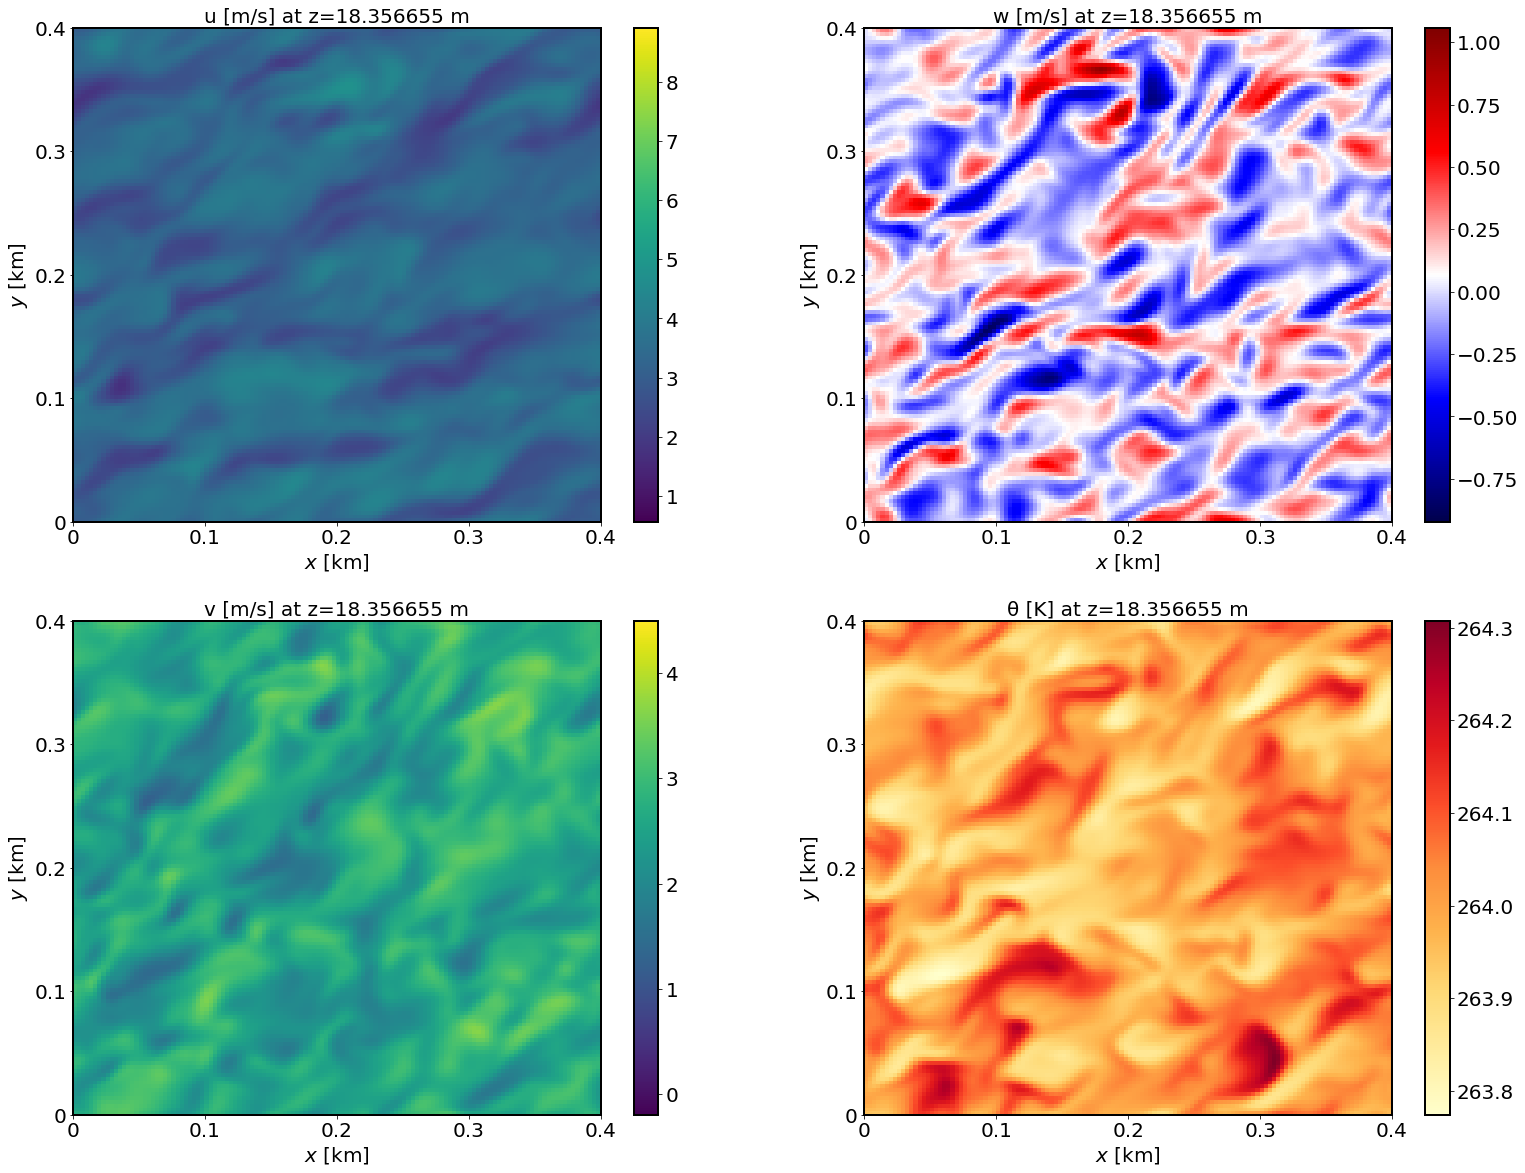

In [147]:
plot_XY_UVWTHETA(case,save_plot_opt)

# 4. Plot XZ cross sections 

972.0
/glade/scratch/erichend/FastEddy/plots/tutorial/UVWTHETA-XZ-stable.png


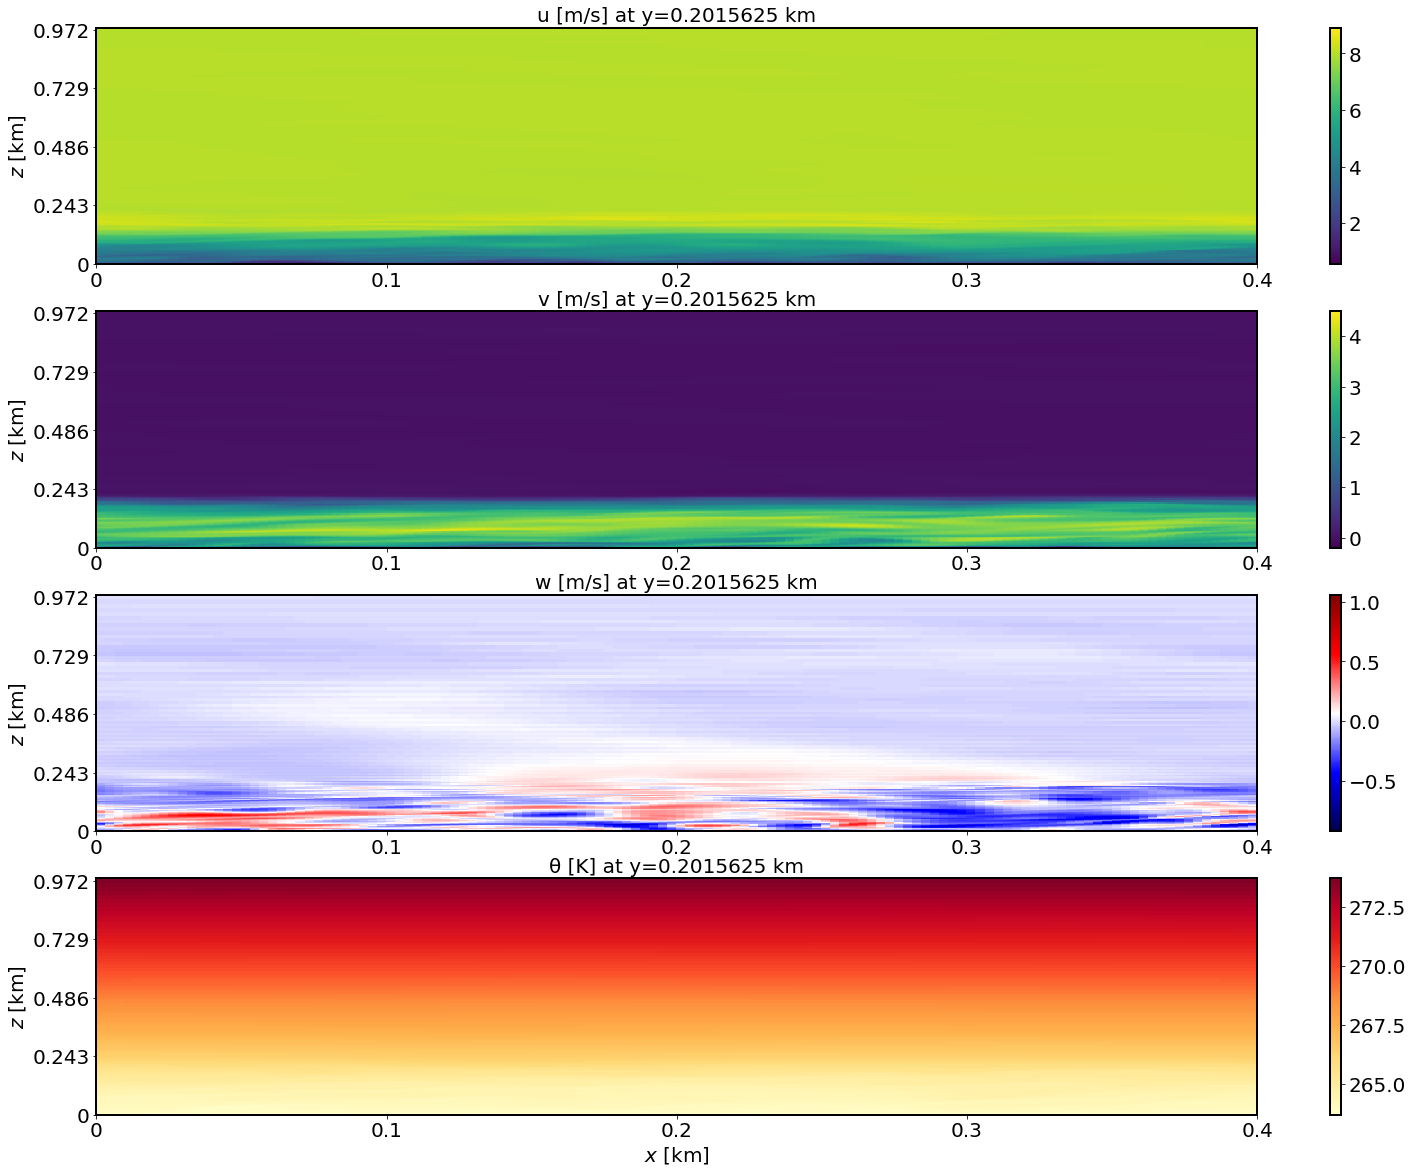

In [148]:
plot_XZ_UVWTHETA(case,save_plot_opt)

# 5. Plot mean vertical profiles 

(122, 128)
0.972
/glade/scratch/erichend/FastEddy/plots/tutorial/MEAN-PROF-stable.png


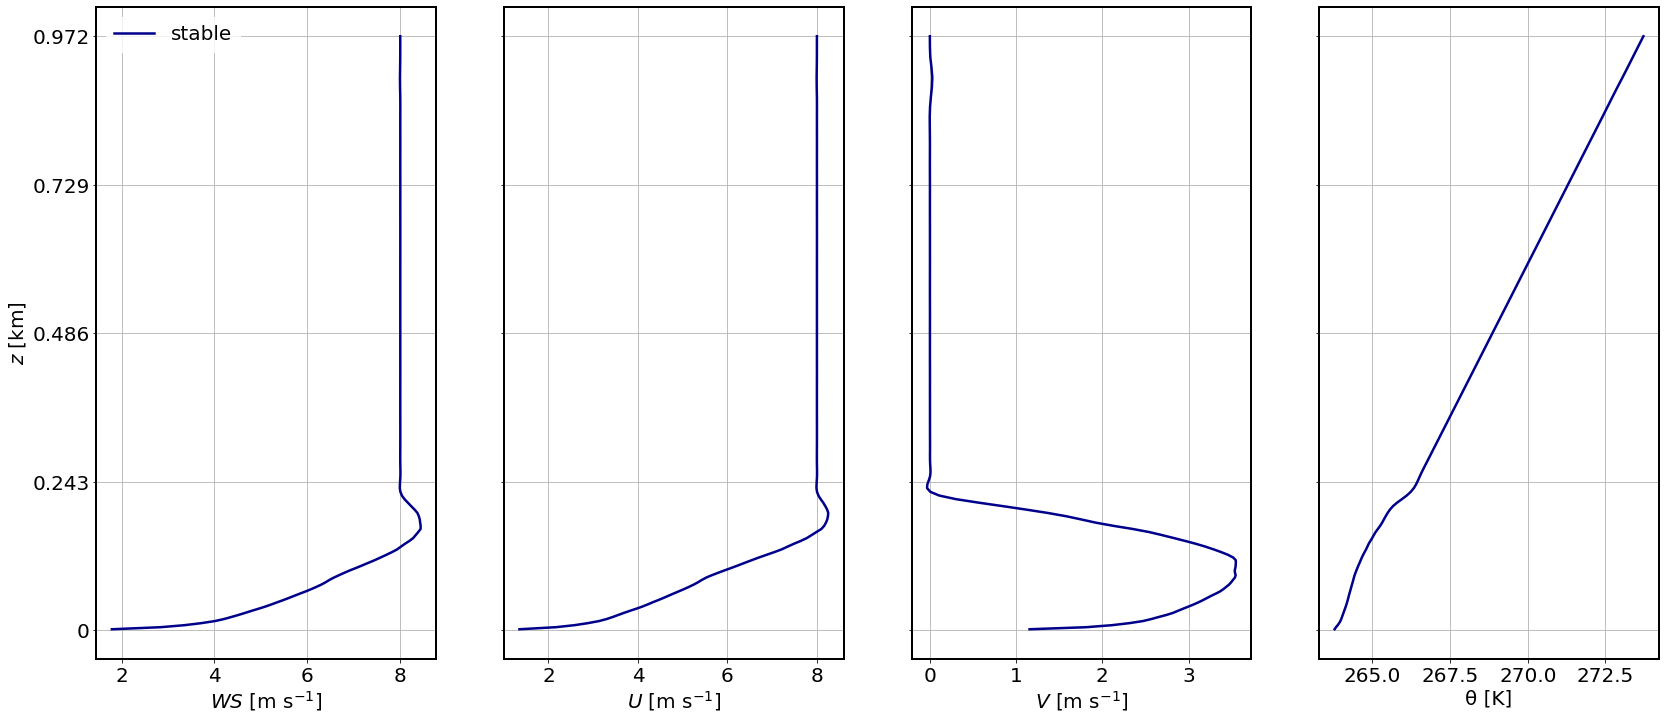

In [149]:
plot_mean_profiles(case, save_plot_opt)

# 6. Plot turbulence profiles

In [150]:
FE_turb_tmp=0.0
for dd in range(0,len(FE_timestep_avg)):
    file_FE_tmp = path_base+cases_FE[indCase]+path_end+output_base[indCase]+FE_timestep_avg[dd]
    print(file_FE_tmp)
    FE_turb_xr_tmp = xr.open_dataset(file_FE_tmp)
    FE_turb_tmp = compute_turb_profiles(FE_turb_xr_tmp, FE_turb_tmp)
    
print(FE_turb_tmp.shape)

/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.3600000
/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.3780000
/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.3960000
/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.4140000
/glade/scratch/erichend/FastEddy/tutorial/stable3/output/FE_SBL.4320000
(122, 15)


stable
/glade/scratch/erichend/FastEddy/plots/tutorial/TURB-PROF-stable.png


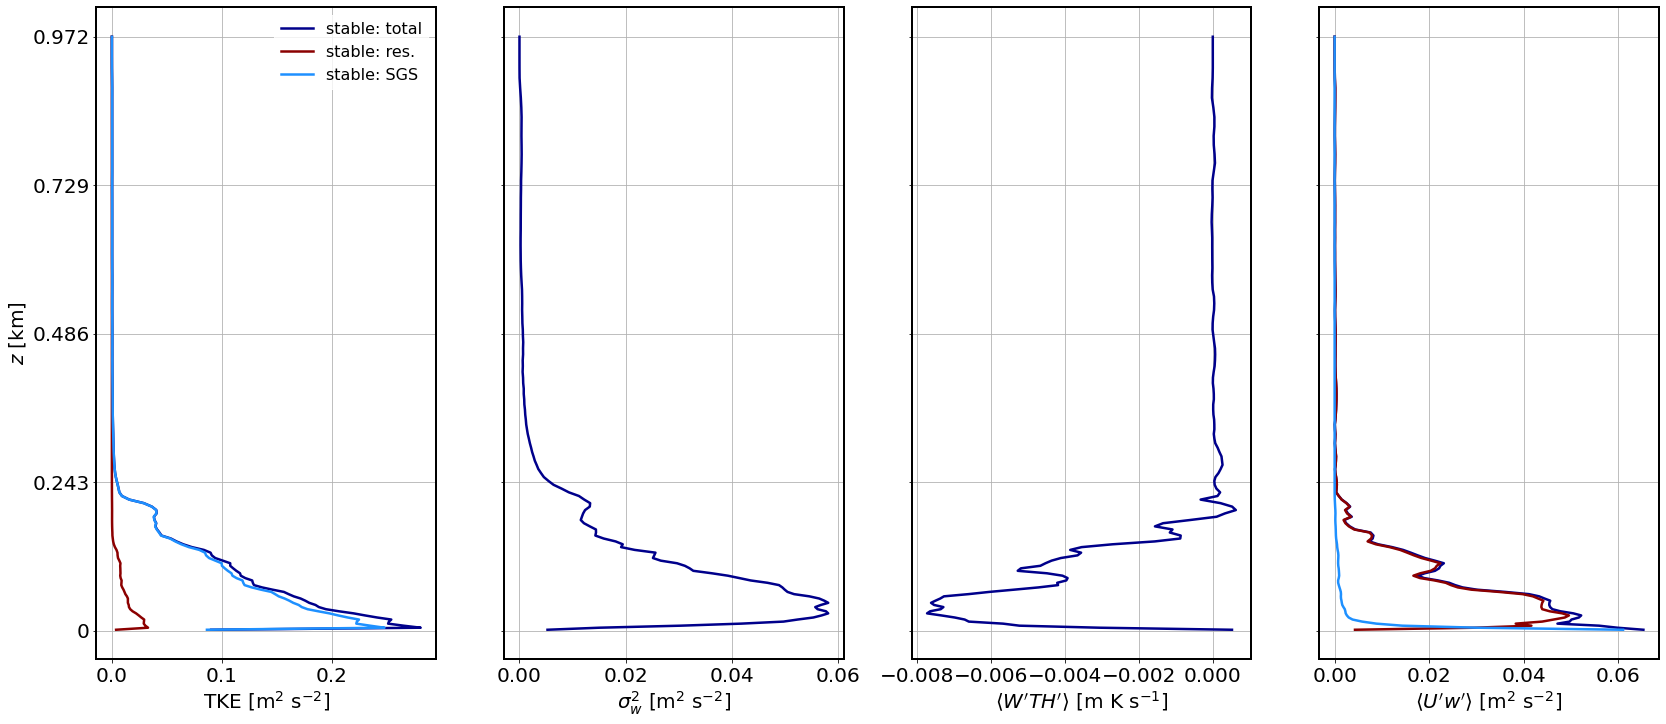

In [151]:
plot_turb_profiles(case,FE_turb_tmp,save_plot_opt)

In [152]:
# Other plots TBD (time averages, turbulence fluxes, etc.)